In [1]:
%load_ext autoreload
%autoreload 2

import os
import gym
import numpy as np
from matplotlib import pyplot as plt
from td3_torch.td3_torch import Agent  # Make sure this import matches your TD3 implementation
from envs.escape_room_continuous_space_env import EscapeRoomEnv
from tqdm.notebook import tqdm  # Using notebook version of tqdm for better integration


In [2]:

def train_td3(alpha=0.001, beta=0.001, tau=0.005, n_games=10):
    env = EscapeRoomEnv()
    agent = Agent(
        alpha=alpha,
        beta=beta,
        input_dims=env.observation_space.shape,
        tau=tau,
        env=env,
        batch_size=64,
        layer1_size=400,
        layer2_size=300,
        n_actions=env.action_space.shape[0]
    )

    filename = f"TD3_EscapeRoom_alpha_{alpha}_beta_{beta}_{n_games}_games"
    figure_file = f"plots/{filename}.png"

    # Ensure the 'plots' directory exists
    if not os.path.exists('plots'):
        os.makedirs('plots')

    score_history = []
    critic_losses = []
    actor_losses = []

    save_interval = n_games // 10
    pbar = tqdm(range(n_games), desc="Training Progress")

    for i in pbar:
        state, _ = env.reset()
        done = False
        score = 0

        while not done:
            action = agent.choose_action(state)
            next_state_info, reward, terminated, truncated, info = env.step(action)
            next_state = next_state_info  # Assuming next_state_info is correctly formatted
            done = terminated or truncated

            agent.remember(state, action, reward, next_state, done)
            learn_outputs = agent.learn()
            if learn_outputs:
                critic_loss, actor_loss = learn_outputs
            else:
                critic_loss, actor_loss = (0, 0)  # Default values when learning doesn't happen

            score += reward
            state = next_state

        score_history.append(score)
        critic_losses.append(critic_loss)
        actor_losses.append(actor_loss)

        avg_score = np.mean(score_history)  # Calculate average score after appending current score

         # Check if 'info' is not None before accessing 'reason'
        info_reason = info['reason'] if info is not None and 'reason' in info else "N/A"

        if (i % save_interval == 0 or i == n_games - 1):  # Save model and plot at intervals
            agent.save_models()

        pbar.set_description(
            f"Episode {i}: Score {score:.1f}, Info : {info_reason}, Average Score {avg_score:.3f}, Actor Losses {actor_losses[-1]:.3f}, Critic Losses {critic_losses[-1]:.3f}")

    return score_history, critic_losses, actor_losses, figure_file


In [3]:
score_history, critic_losses, actor_losses, figure_file = train_td3()


/home/nitin/.local/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/nitin/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving c

In [8]:
import torch
def plot_training_results(x, scores, critic_losses, actor_losses, figure_file):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    axs[0].plot(x, scores, label='Score per Episode', color='blue')
    axs[0].set_title('Scores Over Episodes')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Score')
    axs[0].legend()
    axs[0].grid(True)

    # Convert CUDA tensors to CPU tensors before plotting
    critic_losses_cpu = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in critic_losses]
    axs[1].plot(x, critic_losses_cpu, label='Critic Loss per Episode', color='red')
    axs[1].set_title('Critic Loss Over Episodes')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(True)

    # Convert CUDA tensors to CPU tensors before plotting
    actor_losses_cpu = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in actor_losses]
    axs[2].plot(x, actor_losses_cpu, label='Actor Loss per Episode', color='green')
    axs[2].set_title('Actor Loss Over Episodes')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Loss')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.savefig(figure_file)
    plt.show()


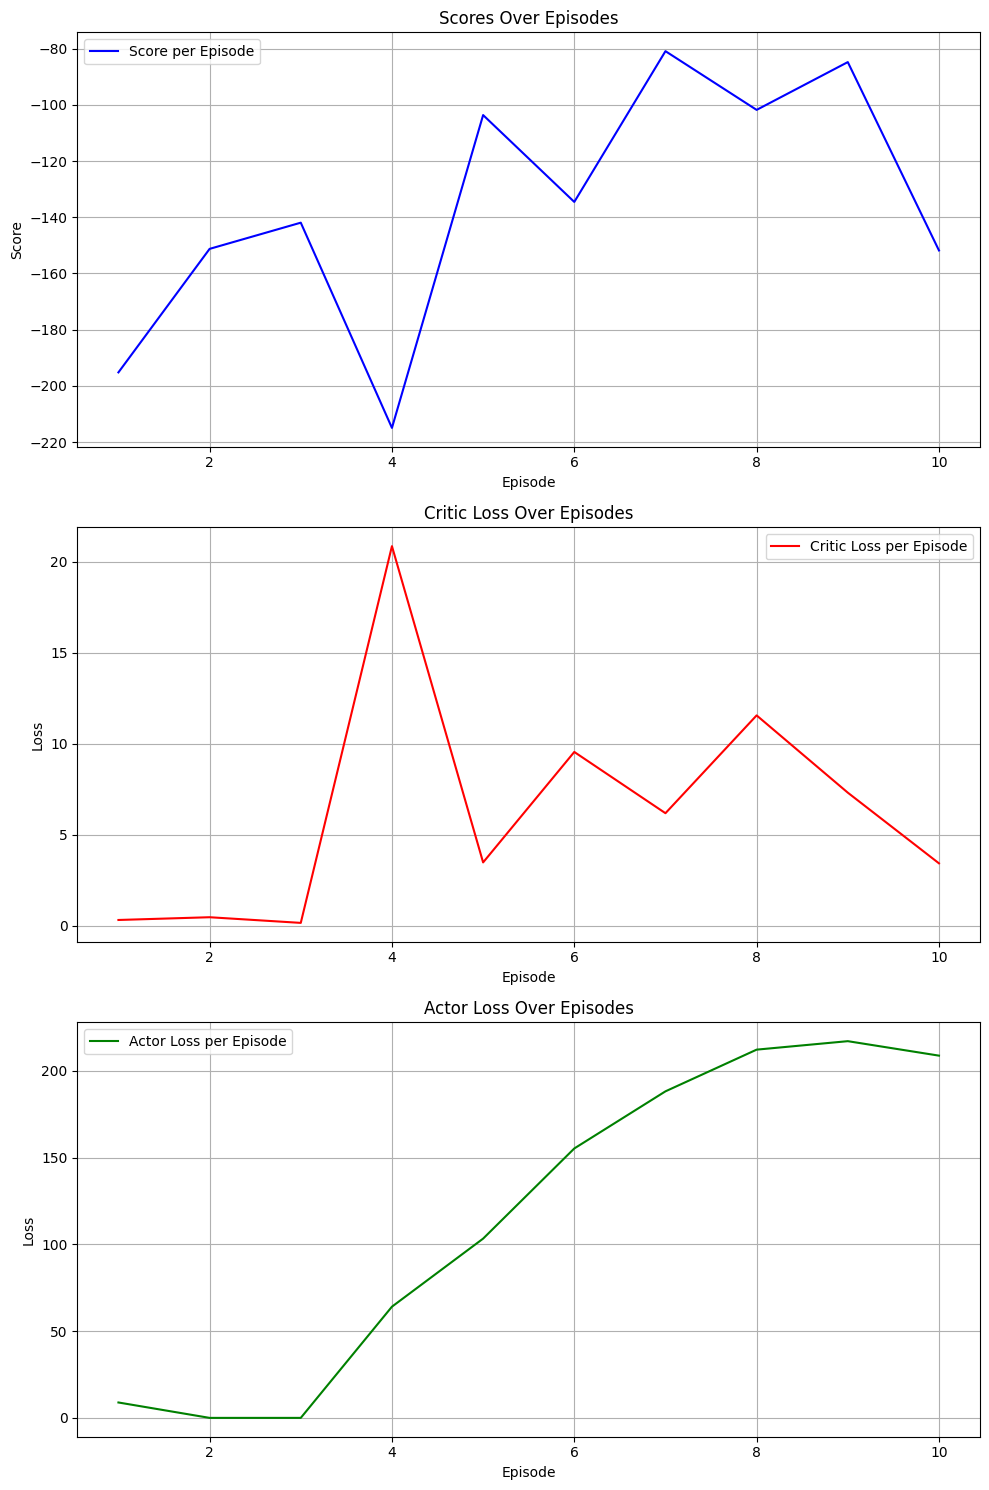

In [9]:
episodes = list(range(1, len(score_history) + 1))
plot_training_results(episodes, score_history, critic_losses, actor_losses, figure_file)

In [12]:
def load_and_simulate(env, agent, n_episodes=5, max_steps=500):
    rewards = []
    steps_per_episode = []

    for episode in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0

        while not done:
            action = agent.choose_action(state)  # Remove the 'noise' argument
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1

            if steps >= max_steps:
                break

        print(f"Episode {episode + 1}: Total reward = {total_reward}, Steps = {steps}")
        rewards.append(total_reward)
        steps_per_episode.append(steps)

    env.close()  # Close the environment when done
    return rewards, steps_per_episode


In [13]:
def main():
    env = EscapeRoomEnv(max_steps_per_episode=500)
    agent = Agent(
        alpha=0.0001,
        beta=0.001,
        input_dims=env.observation_space.shape,
        tau=0.001,
        env=env,  # Add the 'env' argument here
        n_actions=env.action_space.shape[0],
        batch_size=64,
    )

    # Assume agent.load_models is properly implemented
    agent.load_models()

    rewards, steps_per_episode = load_and_simulate(env, agent, n_episodes=5, max_steps=1000)

if __name__ == "__main__":
    main()


... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
Episode 1: Total reward = -19.19154714066284, Steps = 500
Episode 2: Total reward = -36.52643000153345, Steps = 500
Episode 3: Total reward = -52.06620975714684, Steps = 500
Episode 4: Total reward = -25.910137798325735, Steps = 500
Episode 5: Total reward = -25.798011532710984, Steps = 500
